# 🧠 Sentiment Analysis using BERT on IMDb Dataset
This notebook fine-tunes BERT for binary text classification (Positive / Negative reviews).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/NLP_BERT_dataset/IMDB Dataset.csv"

import pandas as pd
df = pd.read_csv(data_path)
print(df.head())
print(df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)


In [2]:
df["label"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
df = df[["review", "label"]]
print(df["label"].value_counts())

label
1    25000
0    25000
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)
print("Train size:", len(train_texts))
print("Test size:", len(test_texts))

Train size: 40000
Test size: 10000


In [4]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn -q

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [8]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [21]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"
)

In [22]:
from torch.utils.data import Subset

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=Subset(train_dataset, range(8000)),
    eval_dataset=Subset(test_dataset, range(2000)),
    compute_metrics=compute_metrics,
)

eval_dataset = Subset(test_dataset, range(2000))

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.104400,0.531360,0.899000,0.899101,0.877193,0.922131
2,0.102300,0.532716,0.906000,0.903292,0.907025,0.899590


TrainOutput(global_step=2000, training_loss=0.10086476370692253, metrics={'train_runtime': 921.9686, 'train_samples_per_second': 17.354, 'train_steps_per_second': 2.169, 'total_flos': 2104888442880000.0, 'train_loss': 0.10086476370692253, 'epoch': 2.0})

In [24]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.5327157974243164, 'eval_accuracy': 0.906, 'eval_f1': 0.9032921810699589, 'eval_precision': 0.9070247933884298, 'eval_recall': 0.8995901639344263, 'eval_runtime': 31.0662, 'eval_samples_per_second': 64.379, 'eval_steps_per_second': 8.047, 'epoch': 2.0}


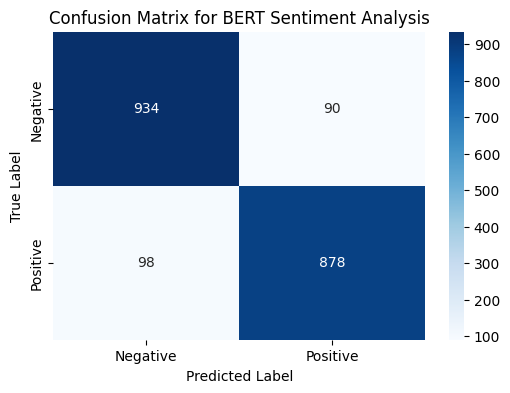

In [25]:
predictions = trainer.predict(eval_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BERT Sentiment Analysis')
plt.show()

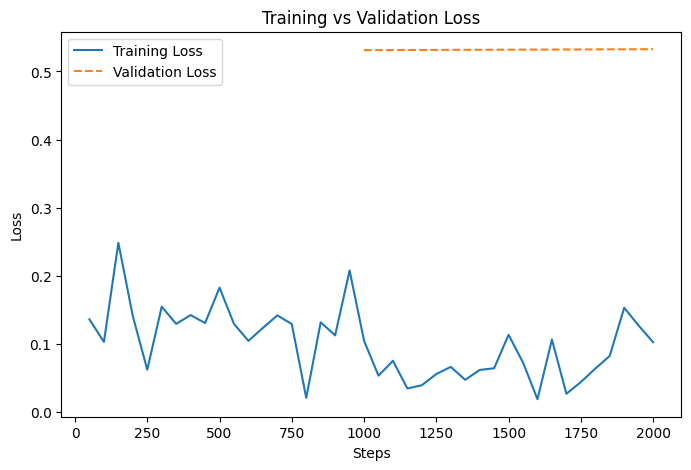

In [26]:
log_history = trainer.state.log_history

train_steps = [x["step"] for x in log_history if "loss" in x.keys()]
train_loss = [x["loss"] for x in log_history if "loss" in x.keys()]

eval_steps = [x["step"] for x in log_history if "eval_loss" in x.keys()]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x.keys()]


plt.figure(figsize=(8,5))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss", linestyle='--')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [28]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move input tensors to the same device as the model
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits).item()
    return "Positive 😊" if pred == 1 else "Negative 😞"

print(predict_sentiment("The movie was outstanding and emotional!"))
print(predict_sentiment("The plot was boring and predictable."))

Positive 😊
Negative 😞


In [29]:
model.save_pretrained("/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model")

('/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model/vocab.txt',
 '/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model/added_tokens.json')

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Define the path where you saved the model
save_directory = "/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model"

# Load the tokenizer and model
loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)

# Ensure the loaded model is on the correct device (GPU if available)
loaded_model.to(model.device)

def predict_sentiment_with_loaded_model(text):
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move input tensors to the same device as the model
    inputs = {key: val.to(loaded_model.device) for key, val in inputs.items()}
    outputs = loaded_model(**inputs)
    pred = torch.argmax(outputs.logits).item()
    return "Positive 😊" if pred == 1 else "Negative 😞"

# Now you can use the loaded model to predict sentiment
print("Prediction using loaded model:")
print(predict_sentiment_with_loaded_model("This movie was fantastic!"))
print(predict_sentiment_with_loaded_model("I did not enjoy this film at all."))

Prediction using loaded model:
Positive 😊
Negative 😞


In [31]:
%%writefile app.py
import streamlit as st
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Define the path where you saved the model
save_directory = "/content/drive/MyDrive/NLP_BERT_dataset/bert_sentiment_model"

# Load the tokenizer and model (with caching)
@st.cache_resource
def load_model(save_directory):
    tokenizer = BertTokenizer.from_pretrained(save_directory)
    model = BertForSequenceClassification.from_pretrained(save_directory)
    # Ensure the loaded model is on the correct device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model

tokenizer, model = load_model(save_directory)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move input tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits).item()
    return "Positive 😊" if pred == 1 else "Negative 😞"

# Streamlit App Interface
st.title("IMDb Movie Review Sentiment Analysis")
st.write("Enter a movie review below to get a sentiment prediction.")

user_input = st.text_area("Enter Review Here:")

if st.button("Analyze Sentiment"):
    if user_input:
        sentiment = predict_sentiment(user_input)
        st.write(f"Predicted Sentiment: {sentiment}")
    else:
        st.write("Please enter a review to analyze.")

Writing app.py


In [32]:
!pip install streamlit -q
!pip install pyngrok -q
from pyngrok import ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 143.0 MB/s eta 0:00:00


In [37]:
# Terminate any active ngrok tunnels
ngrok.kill()

# Set your authentication token. Get it from https://dashboard.ngrok.com/get-started/your-authtoken
# Replace 'YOUR_AUTHTOKEN' with your actual ngrok authentication token
ngrok.set_auth_token("34dedk20Uqh7EltYIKQJfx4Tx4V_6TEEqxfrhoT97ruskGenX")

# Open a tunnel to the Streamlit port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Streamlit app available at: {public_url}")

Streamlit app available at: NgrokTunnel: "https://remiform-judy-heptarchical.ngrok-free.dev" -> "http://localhost:8501"


In [38]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.61.250:8501

2025-10-27 07:02:08.791494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761548528.814378   30239 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761548528.821205   30239 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761548528.837852   30239 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761548528.837882   30239 computation_placer.cc:177] computation placer al